## Семинар 2 "Распознавание рукописных цифр"

ФИО: Радионов Максим Анатольевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        np.random.seed(5)
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy
    
    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] =1
        return -(np.log(self.p)*self.y).sum(1).mean(0)
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules
    
    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)
    
    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys

from IPython.display import clear_output
%matplotlib inline

In [34]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

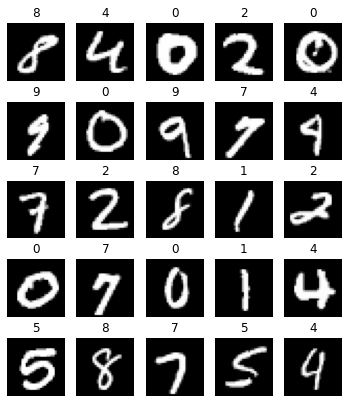

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
def train(network, train_loader, test_loader, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [7]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.322/0.316	Accuracy: 0.916/0.916

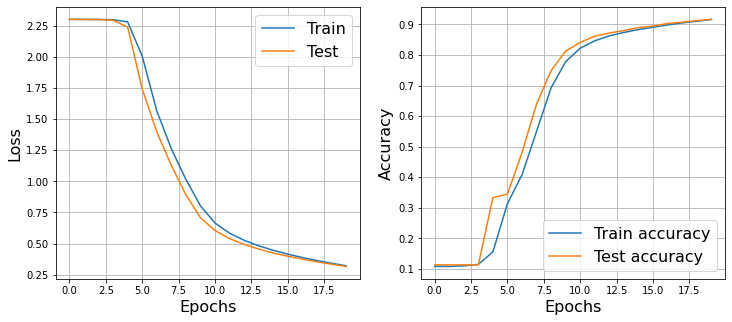

CPU times: user 8min 55s, sys: 5min 49s, total: 14min 45s
Wall time: 7min 32s


In [8]:
%%time
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, train_loader, test_loader, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [9]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [10]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.090	Accuracy: 0.990/0.974

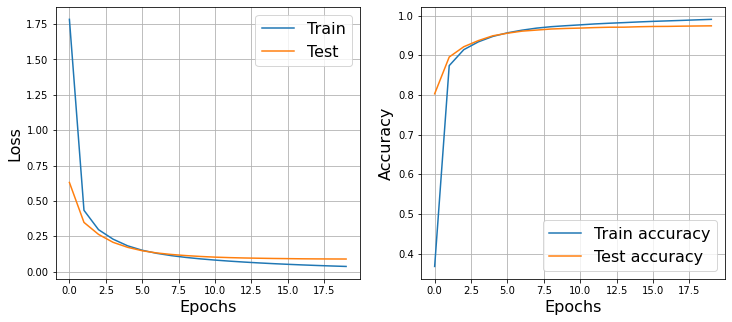

CPU times: user 8min 33s, sys: 5min 34s, total: 14min 8s
Wall time: 7min 13s


In [38]:
%%time
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader, test_loader, 20, 0.01, plot=True, verbose=True)

In [26]:
%%time
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, train_loader, test_loader, 20, 0.01, plot=True, verbose=True)

CPU times: user 1.87 s, sys: 1.21 s, total: 3.07 s
Wall time: 1.58 s


### HW1 (1 балл): Реализовать Tanh

In [13]:
class Th:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return (np.exp(2*X) - 1) / (np.exp(2*X) + 1)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 4 / ((np.exp(X) + np.exp(-X))**2)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [27]:
network = NeuralNetwork([
    Linear(784, 100), Th(),
    Linear(100, 100), Th(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_th, ts_th, tr_ac_th, ts_ac_th = train(network, train_loader, test_loader, 20, 0.01, plot=True, verbose=True)

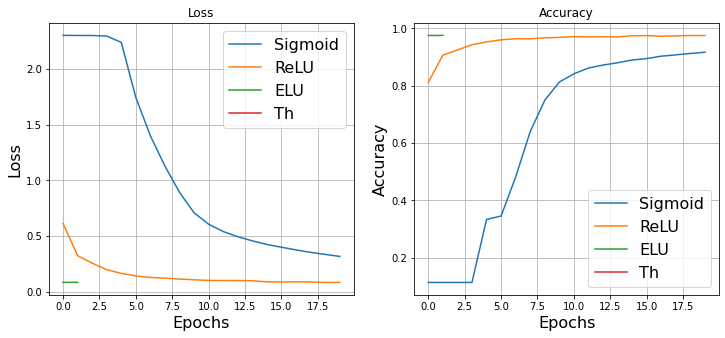

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_th, label='Th')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_th, label='Th')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()  

### Часть 3: Анализ ошибок

In [16]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)#softmax
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

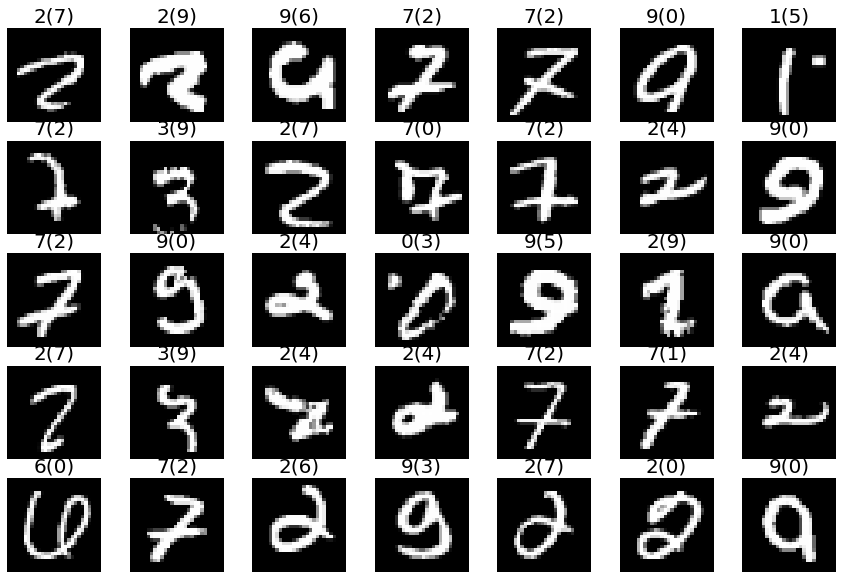

In [17]:
plt.figure(figsize=(15, 10))
order = np.argsort(logits)
for i in range(35):
    plt.subplot(5, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Аугментация

In [18]:
from torch import randn
def noise(x_old):
  return x_old + 0.02*randn(x_old.shape)

Вращение


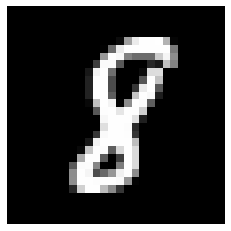

Сдвиг


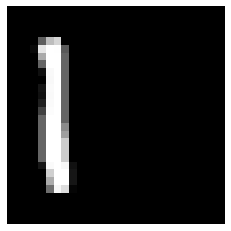

Шум


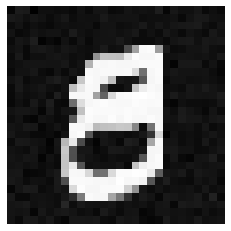

In [19]:
#Визуально протестируем трансформации

def plot_pic(x):
    plt.imshow(x.reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')
    plt.show()

transform = transforms.Compose([
                       transforms.RandomRotation((90, -90), resample=False, expand=False, center=None, fill=None),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print('Вращение')
plot_pic(next(iter(train_loader))[0][0][0].numpy())

transform = transforms.Compose([
                       transforms.RandomAffine(0, translate=(0.5,0.1), scale=None, shear=None, resample=False, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print('Сдвиг')
plot_pic(next(iter(train_loader))[0][0][0].numpy())

transform = transforms.Compose([
                       transforms.ToTensor(),
                       noise,
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print('Шум')
plot_pic(next(iter(train_loader))[0][0][0].numpy())

In [41]:
def train_with_transform(transform):
  train_dataset = MNIST('.', train=True, download=True, transform=transform)
  test_dataset = MNIST('.', train=False, transform=transform)
  
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
  
  network = NeuralNetwork([
      Linear(784, 100), ReLU(),
      Linear(100, 100), ReLU(),
      Linear(100, 10)
  ])
  loss = NLLLoss()
  return train(network, train_loader, test_loader, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.037/0.090	Accuracy: 0.990/0.974

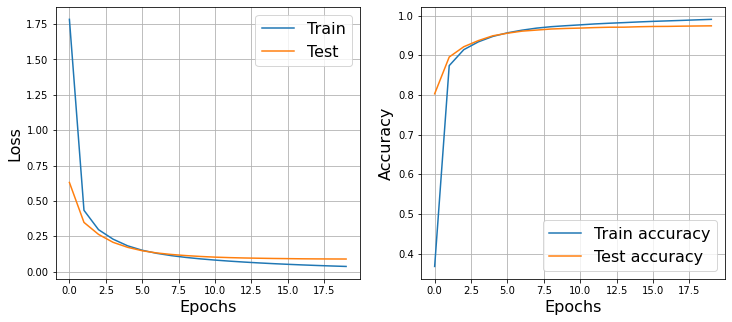

In [45]:
#Вращение
transform = transforms.Compose([
                transforms.RandomRotation(15, resample=False, expand=False, center=None, fill=None),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train_with_transform(transform)

Вращения не помогли. Попробуем подобрать угол, при этом зафиксируем все рандом сиды и отключим шафл

Epoch 19... (Train/Test) NLL: 0.074/0.094	Accuracy: 0.978/0.971

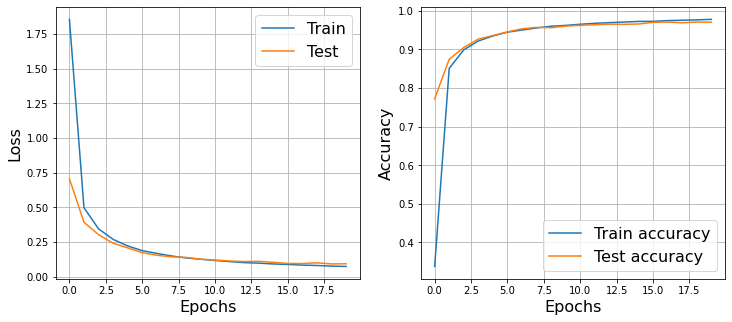

100%|██████████| 15/15 [2:12:40<00:00, 530.70s/it]


In [47]:
from tqdm import tqdm
test = []
for angel in tqdm(range(1, 16)):
  transform = transforms.Compose([
                  transforms.RandomRotation(angel, resample=False, expand=False, center=None, fill=None),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                      ])
  tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train_with_transform(transform)
  test.append(ts_ac_rot[-1])

0.00019968051118213204


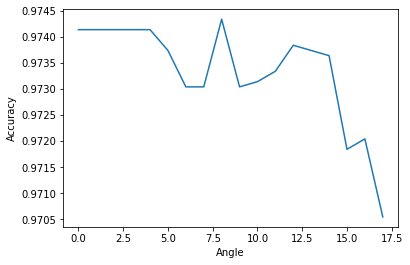

In [57]:
test.insert(0,ts_ac_r[-1] )
plt.ylabel('Accuracy')
plt.xlabel('Angle')
plt.plot(test)
delta = max(test)-ts_ac_r[-1] 
print(delta)
#очень маленькое улучшение при 7 градусах

Улучшений ни видно. На остальных трансформациях не будем подбирать параметры, это очень долго

Epoch 19... (Train/Test) NLL: 0.115/0.116	Accuracy: 0.966/0.961

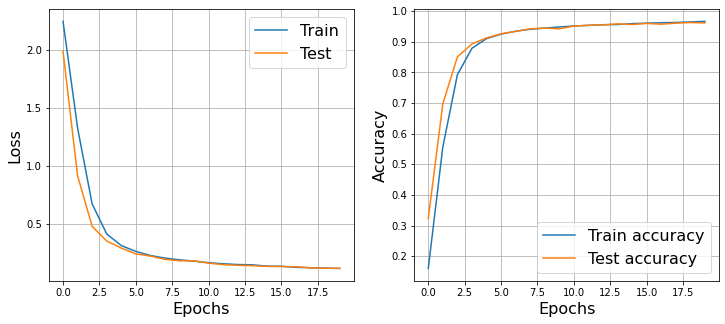

In [58]:
#сдвиги
transform = transforms.Compose([
                       transforms.RandomAffine(0, translate=(0.1,0.1), scale=None, shear=None, resample=False, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
tr_sh, ts_sh, tr_ac_sh, ts_ac_sh= train_with_transform(transform)

Epoch 19... (Train/Test) NLL: 0.037/0.090	Accuracy: 0.990/0.973

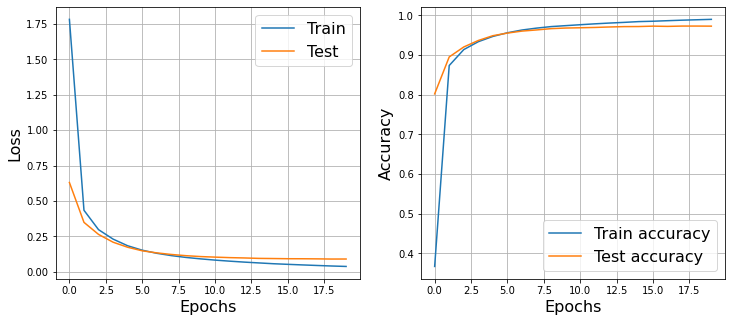

In [59]:
#шум
transform = transforms.Compose([
                       transforms.ToTensor(),
                       noise,
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
tr_noise, ts_noise, tr_ac_noise, ts_ac_noise= train_with_transform(transform)

Epoch 19... (Train/Test) NLL: 0.145/0.144	Accuracy: 0.956/0.952

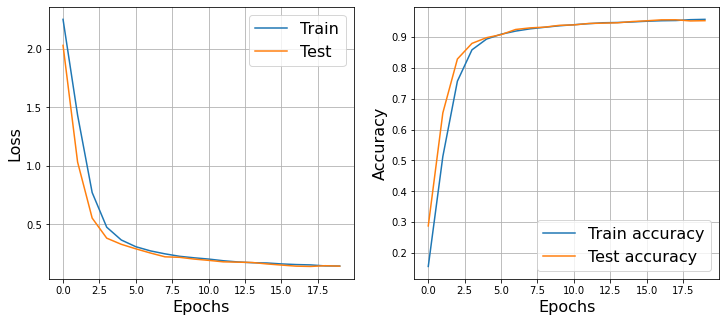

In [60]:
#все вместе
transform = transforms.Compose([
                       transforms.RandomRotation(15, resample=False, expand=False, center=None, fill=None),
                       transforms.RandomAffine(0, translate=(0.1,0.1), scale=None, shear=None, resample=False, fillcolor=0),
                       transforms.ToTensor(),
                       noise,
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
tr_all, ts_all, tr_ac_all, ts_ac_all= train_with_transform(transform)


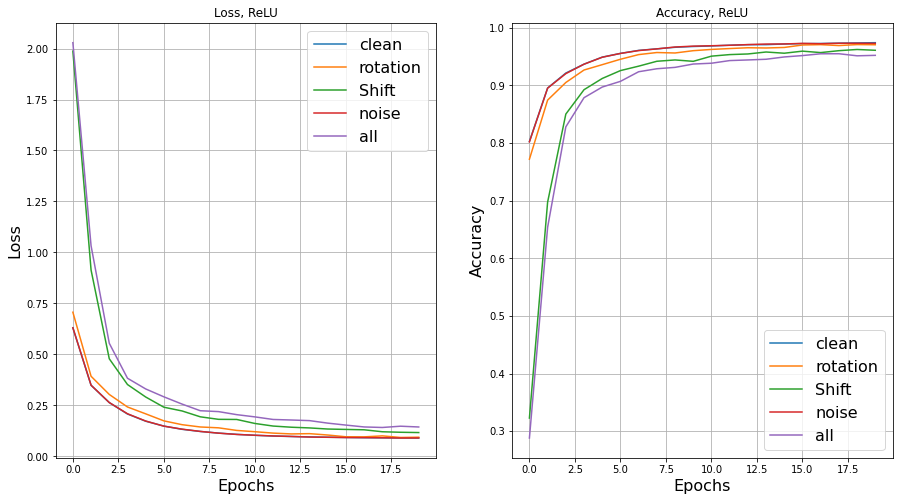

In [66]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title('Loss, ReLU')
plt.plot(ts_r, label='clean')
plt.plot(ts_rot, label='rotation')
plt.plot(ts_sh, label='Shift')
plt.plot(ts_noise, label='noise')
plt.plot(ts_all, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy, ReLU')
plt.plot(ts_ac_r, label='clean')
plt.plot(ts_ac_rot, label='rotation')
plt.plot(ts_ac_sh, label='Shift')
plt.plot(ts_ac_noise, label='noise')
plt.plot(ts_ac_all, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Очевидно из нелинейностей сигмоида показала себя хуже всех. Тангенс оказался не хуже чем relu и elu. Странно, но аугментация не дала никакой прибавки. Даже подбор угла поворота не помог. Возможно эффект был бы виден на большем колличестве эпох, но это очень долго